In [1]:
import numpy as np
import pandas as pd
import pyarrow
import fastparquet
from pandasql import sqldf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


/Users/isabellajohansson/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Data pre processing: ....copied from before
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')
advances = pd.read_parquet("data_science_take_home_advances.parquet", engine='pyarrow')

###1. Convert 'account_id' to numerical values
# Create a copy of the 'account_id' column as 'account_id_string'
transactions['account_id_string'] = transactions['account_id'].copy()
advances['account_id_string'] = advances['account_id'].copy()

label_encoder = LabelEncoder() # Create a label encoder object

transactions['account_id'] = label_encoder.fit_transform(transactions['account_id']) # Transform 'account_id' column to numerical values and replace the original column 
advances['account_id'] = label_encoder.fit_transform(advances['account_id'])

###2. Only looking at postivie numbers and ignoring charges (for now?).
#Noticed that for payment_channel: "online" and "in-store" can be filtered out bc they seem to exclude salaries.
selected_data = transactions[(transactions['payment_channel'] != 'online') &
                             (transactions['payment_channel'] != 'in store') &
                             (transactions['f0_'] > 0)] 
###3. Lets ignore irrelevant columns: 

columns_to_remove = ['account_id_string', 'month', 'week_number','version', 'currency_code', 'pending', 'removed', 'selected_data', 'city', 'region', 'payment_meta_payment_processor',
                    'authorized_date', 'payment_meta_payment_method', 'payment_channel', 'bank_account_id', 'day_of_week' , 'week_number', 'month','id']
cleaned_data = selected_data.drop(columns=columns_to_remove, axis=1, errors='ignore')

# Let's ensure the 'date' column is converted to a datetime format before using the .dt accessor. 
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Feature Engineering: Extract features from dates and descriptions
cleaned_data['day_of_week'] = cleaned_data['date'].dt.dayofweek
cleaned_data['week_number'] = cleaned_data['date'].dt.isocalendar().week
cleaned_data['month'] = cleaned_data['date'].dt.month

cleaned_data

,account_id,f0_,date,name,day_of_week,week_number,month
4,1665,54.18,2021-11-24,"VISA TRANSFER, *****30100057355, AUT 112321 VI...",2,47,11
11,1665,200.00,2021-11-10,"ATM CASH DEPOSIT, *****3010005735",2,45,11
14,1665,60.00,2022-09-01,"ACH DEPOSIT, WISELY ACH P2PTRANSFR 8683261 J ROM",3,35,9
16,1665,1135.21,2022-09-23,"ACH DEPOSIT, CTC ACADEMY INC DIRECT DEP ****85...",4,38,9
18,1665,300.00,2022-03-01,"ATM CASH DEPOSIT, *****3010005735",1,9,3
...,...,...,...,...,...,...,...
1962474,1201,92.00,2022-10-21,Zayzoon Payout CHEYENNE WY 125560 10/2,4,42,10
1962475,1201,94.00,2022-09-02,Zayzoon Payout CHEYENNE WY 153665 09/0,4,35,9
1962476,1201,94.00,2022-09-30,Zayzoon Payout CHEYENNE WY 207757 09/3,4,39,9
1962477,1201,84.00,2022-12-02,Zayzoon Payout CHEYENNE WY 455830 12/0,4,48,12


# Clustering transactions based on small variance in the transaction names for particular income sources

In [3]:
#code below did not run...the computation is taking too long or causing memory issues

#I will filter out transactions under 500

#cleaned_data = cleaned_data[cleaned_data['f0_'] >= 500]
#len(cleaned_data)


#lets instead only look at one account:
# Filter transactions for the specified account_id
account_data = cleaned_data[cleaned_data['account_id'] ==1665]

In [4]:
len(account_data)

356

# How to choose number of clusters?

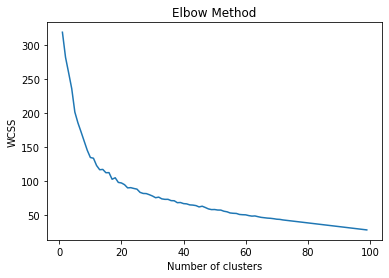

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'account_data' with a column 'name'

# Step 1: Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(account_data['name'])

# Step 2: Elbow Method
wcss = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Step 1: Tokenize the names
tokenized_names = [name.split() for name in account_data['name']]

# Step 2: Vectorize the tokens
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in tokenized_names])

# Step 3: Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 4: Cluster the names
num_clusters = 20  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(cosine_sim)

# Assign cluster labels to names
account_data['cluster'] = kmeans.labels_

# Display the clustered names
account_data





/var/folders/4n/8gw9ph8s2412c5b823zm40fw0000gp/T/ipykernel_23471/3890456358.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['cluster'] = kmeans.labels_


,account_id,f0_,date,name,day_of_week,week_number,month,cluster
4,1665,54.18,2021-11-24,"VISA TRANSFER, *****30100057355, AUT 112321 VI...",2,47,11,3
11,1665,200.00,2021-11-10,"ATM CASH DEPOSIT, *****3010005735",2,45,11,0
14,1665,60.00,2022-09-01,"ACH DEPOSIT, WISELY ACH P2PTRANSFR 8683261 J ROM",3,35,9,6
16,1665,1135.21,2022-09-23,"ACH DEPOSIT, CTC ACADEMY INC DIRECT DEP ****85...",4,38,9,2
18,1665,300.00,2022-03-01,"ATM CASH DEPOSIT, *****3010005735",1,9,3,0
...,...,...,...,...,...,...,...,...
1943421,1665,75.00,2022-12-19,VISA TRANSFER 494375 INSTACASH FUNDS NEW YORK,0,51,12,14
1943423,1665,30.00,2022-10-17,VISA TRANSFER 494375 MONEYLION TURBO TRANSFER ...,0,42,10,5
1943424,1665,95.00,2022-10-21,VISA TRANSFER 494375 MONEYLION TURBO TRANSFER ...,4,42,10,5
1943425,1665,49.13,2022-11-30,Venm,2,48,11,4


In [47]:
selected_data = account_data.loc[account_data['cluster'] == 16, ['name', 'f0_', 'date']]
selected_data

,name,f0_,date
280460,CTC ACADEMY INC DIRECT DE,1110.06,2022-10-21
420822,CTC ACADEMY INC DIRECT DE,1009.60,2022-10-07
561019,CTC ACADEMY INC DIRECT DE,90.15,2022-12-21
841203,CTC ACADEMY INC DIRECT DE,1205.28,2022-12-02
1260838,CTC ACADEMY INC DIRECT DE,1204.38,2022-11-18
1260845,CTC ACADEMY INC DIRECT DE,1230.01,2022-12-16
1541927,CTC ACADEMY INC DIRECT DE,1192.53,2022-12-30
1682085,CTC ACADEMY INC DIRECT DE,1223.62,2022-11-04


# Plotting transaction amounts f0_ to see if they are consistent

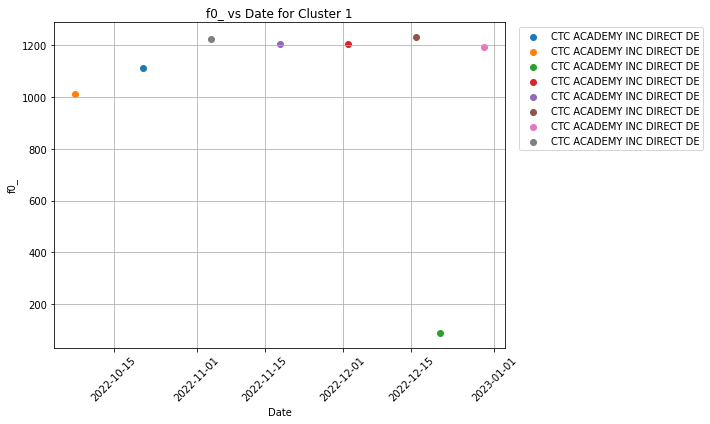

In [38]:
# Convert date and f0_ columns to NumPy arrays
dates = selected_data['date'].values
f0_values = selected_data['f0_'].values
names = selected_data['name'].values

# Plot f0_ vs date as a scatter plot with legend outside
plt.figure(figsize=(10, 6))
for date, f0, name in zip(dates, f0_values, names):
    plt.scatter(date, f0, marker='o', label=name)

plt.xlabel('Date')
plt.ylabel('f0_')
plt.title('f0_ vs Date for Cluster 1')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()

plt.show()

# Next: figure out best way to choose number of cluster--test different methods. Impiment and run for all accounts.. Then we can catogorize income/non-income... 


# Some people get paid with zelle/venmo, how to distingush?